In [52]:
path = '/media/cat/data/noah/IBL_data_CEED/'
path2 = '/home/noah/code/CEED_new/CEED/notebooks/'

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [126]:
for root, dirs, files in os.walk(path):
    if files: #python abuse - empty lists are falsy :)
        print(dirs, files)

# for root, dirs, files in os.walk(path2):
#     if files: #python abuse - empty lists are falsy :)
#         print(files)       

['covariances'] ['labels_train.npy', 'channel_num_train.npy', 'labels_test.npy', 'spikes_val.npy', 'labels_val.npy', 'spikes_test.npy', 'channel_num_val.npy', 'channel_num_test.npy', 'channel_spike_locs_val.npy', 'channel_spike_locs_test.npy', 'spikes_train.npy', 'channel_spike_locs_train.npy']
[] ['temporal_cov_1.npy', 'temporal_cov.npy', 'spatial_cov_1.npy', 'spatial_cov.npy']


In [42]:
#single channel, would be great to have multi channel

In [127]:
spike_locs = np.load(path + 'combined/' + 'channel_spike_locs_test.npy')
geom = np.load(path2 + 'geom_sess2.npy')
spikes = np.load(path + 'combined/' + 'spikes_test.npy')
templates = np.load(path2 + 'templates_sess2.npy')

In [44]:
spike_locs.shape #unit, channel, geometric_location

(22679, 21, 2)

In [78]:
spike_locs[0] #x, depth

print(np.max(spike_locs[:2000,0,0]) - np.min(spike_locs[:2000,0,0])) #

48.0


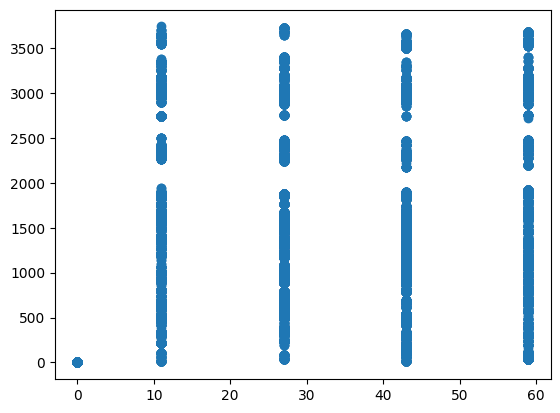

In [80]:
plt.scatter(spike_locs[:,0,0], spike_locs[:,0,1],)
plt.show()

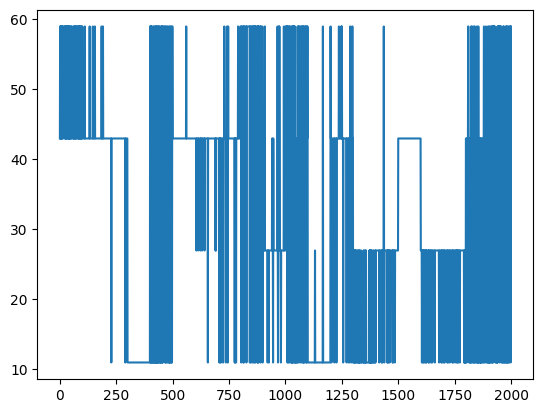

In [83]:
plt.plot(spike_locs[:2000,0,0])

In [86]:
geom.shape

(384, 2)

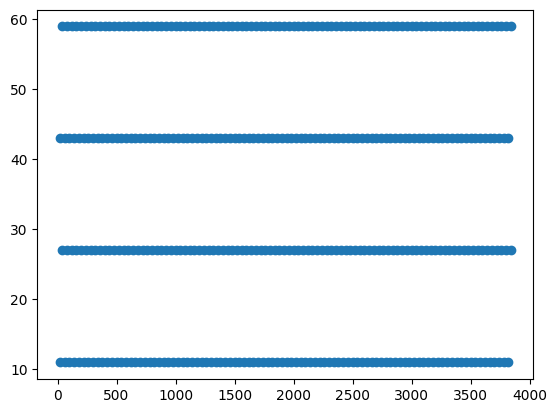

In [91]:
plt.scatter(geom[:,1], geom[:,0])

In [99]:
geom[:,0]

array([43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43.,
       11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11.,
       59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59.,
       27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27.,
       43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43.,
       11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11.,
       59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59.,
       27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27.,
       43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43.,
       11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11.,
       59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59.,
       27., 43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27.,
       43., 11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43.,
       11., 59., 27., 43., 11., 59., 27., 43., 11., 59., 27., 43

In [101]:
# looking at spikes

spikes.shape

(154760, 21, 121)

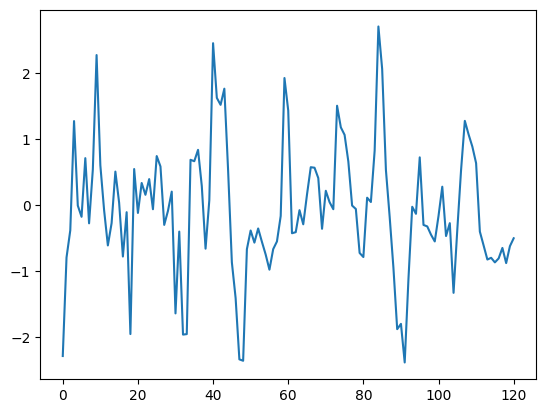

In [122]:
plt.plot(spikes[90,0,:])
plt.show()

In [128]:
templates.shape

(429, 121, 384)

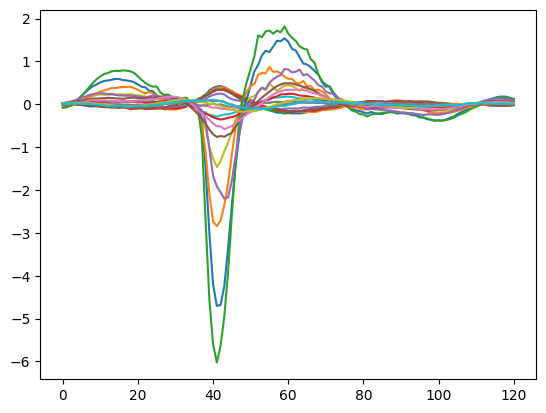

In [134]:
plt.plot(templates[7,:,0:20])
plt.show()

In [133]:
#actual spike data looks terrible

In [ ]:
plt.plot(np.mean(spikes[

In [ ]:
#ceed embedding performance in cell typeing anf spike sorting compared to baseline